<a href="https://colab.research.google.com/github/gmurari30/gmurari30/blob/main/lightgbm_optuna_gbdt_final_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Dictionary:
![image.png](attachment:image.png)

In [ ]:
# data processing
import pandas as pd
import numpy as np

# data viz
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

# customize print
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)
pd.set_option('display.float_format', lambda x: '%.8f' % x)

from sklearn.metrics import classification_report,accuracy_score, roc_curve, roc_auc_score,confusion_matrix, precision_recall_curve,recall_score, precision_score, f1_score,auc

### 1. Import Data

In [ ]:
from google.colab import files
uploaded = files.upload()

data = pd.read_excel("data_clean_completed.xlsx")

Saving data_clean_completed.xlsx to data_clean_completed (2).xlsx


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             59400 non-null  int64  
 1   amount_tsh                     59400 non-null  float64
 2   funder                         59400 non-null  object 
 3   gps_height                     59400 non-null  float64
 4   installer                      55745 non-null  object 
 5   longitude                      59400 non-null  float64
 6   latitude                       59400 non-null  float64
 7   basin                          59400 non-null  object 
 8   region                         59400 non-null  object 
 9   district_code                  59400 non-null  int64  
 10  lga                            59400 non-null  object 
 11  ward                           59400 non-null  object 
 12  population                     59400 non-null 

In [ ]:
data.status_group.value_counts()

0    32259
2    22824
1     4317
Name: status_group, dtype: int64

In [ ]:
# no missing values
data.isna().sum()

id                                  0
amount_tsh                          0
funder                              0
gps_height                          0
installer                        3655
longitude                           0
latitude                            0
basin                               0
region                              0
district_code                       0
lga                                 0
ward                                0
population                          0
public_meeting                      0
scheme_management                   0
permit                              0
construction_year                   0
extraction_type_class               0
management                          0
payment_type                        0
water_quality                       0
quality_group                       0
quantity                            0
source                              0
waterpoint_type                     0
10_yrs                              0
status_group

In [ ]:
data.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type_class,management,payment_type,water_quality,quality_group,quantity,source,waterpoint_type,10_yrs,status_group,gps_height_bad,longitude_bad,latitude_bad,region_encoded,scheme_management_encoded,management_encoded,waterpoint_type_encoded,extraction_type_class_encoded,lga_encoded,ward_encoded,source_encoded,basin_encoded,quantity_encoded,quality_group_encoded,region_district,schemeM_scheme,waterpoint_extraction,extraction_source,basin_qualityG,funder_cat,installer_cat,population_binned,amount_tsh_is_zero,amount_tsh_bin
0,69572,6000.00000000,Romam Catholic Church,1390.00000000,Roman,34.93809275,-9.85632177,Lake Nyasa,Iringa,5,Ludewa,Mundindi,109,True,VWC,False,1999,gravity,vwc,annually,soft,good,enough,spring,communal standpipe,90s,0,0,0,0,3,8,7,1,0,51,1426,8,1,1,2,0,0,0,0,0,17,14,1.00000000,0,5000-360000
1,8776,0.00000000,Grumeti,1399.00000000,GRUMETI,34.69876610,-2.14746569,Lake Victoria,Mara,2,Serengeti,Natta,280,unknown,Other,True,2010,gravity,wug,never pay,soft,good,insufficient,rainwater harvesting,communal standpipe,10s,0,0,0,0,9,2,11,1,0,103,1576,5,4,2,2,1,1,0,1,1,14,14,2.00000000,1,0-1
2,34310,25.00000000,Lottery Club,686.00000000,world vision,37.46066446,-3.82132853,Pangani,Manyara,4,Simanjiro,Ngorika,250,True,VWC,True,2009,gravity,vwc,per bucket,soft,good,enough,dam,communal standpipe multiple,00s,0,0,0,0,8,8,7,2,0,108,1624,0,5,1,2,2,0,1,2,2,14,25,2.00000000,0,1-50
3,67743,0.00000000,Unicef,263.00000000,Unicef,38.48616088,-11.15529772,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,Nanyumbu,58,True,VWC,True,1986,submersible,vwc,never pay,soft,good,dry,machine dbh,communal standpipe multiple,80s,2,0,0,0,12,8,7,2,5,87,1571,3,7,0,2,3,0,2,3,3,21,20,1.00000000,1,0-1
4,19728,0.00000000,Action Aid,1329.26500790,Artisan,31.13084671,-1.82535885,Lake Victoria,Kagera,1,Karagwe,Nyakasimbi,281,True,Unknown,True,2000,gravity,other,never pay,soft,good,seasonal,rainwater harvesting,communal standpipe,00s,0,1,0,0,4,7,1,1,0,26,1687,5,4,3,2,4,2,0,1,1,14,14,2.00000000,1,0-1


### 2. Quick Data Check

Text(0.5, 1.05, 'Pearson correlation of Features')

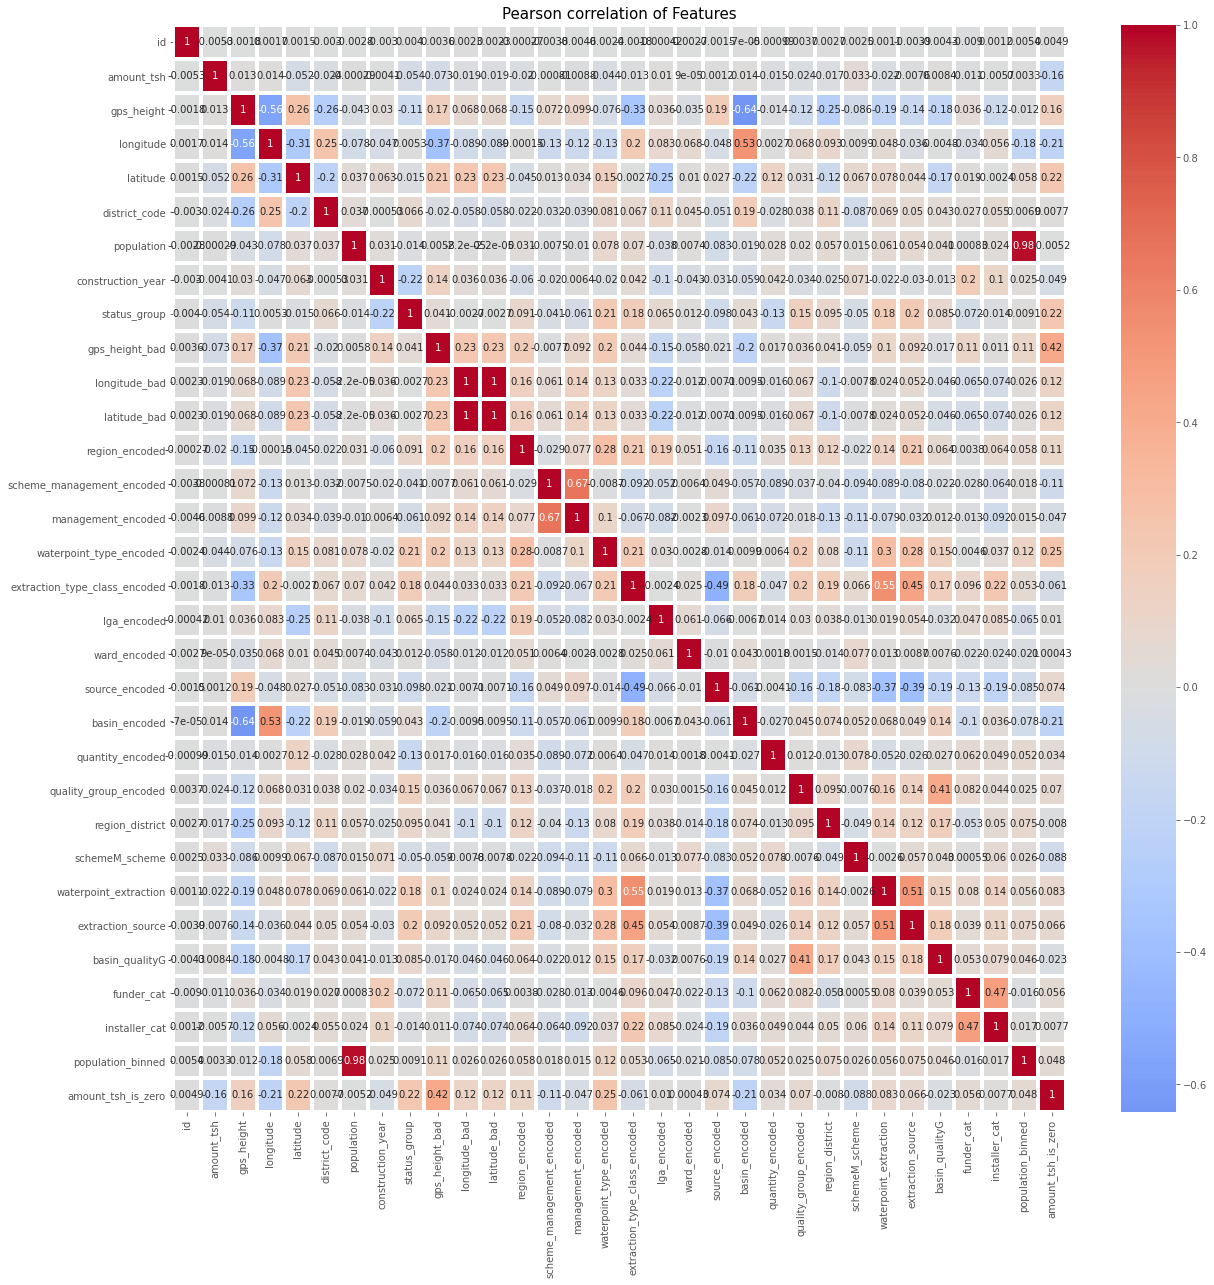

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(), annot = True, cmap = 'coolwarm', linewidths=3,center = 0)
plt.title("Pearson correlation of Features", y=1.05, size=15)

### 3. Data Preprocessing

In [ ]:


X = data[data.columns[~data.columns.isin(['status_group'])]]
y = data['status_group']

print(X.shape)
X.head(3)



(59400, 39)


,id,amount_tsh,funder,gps_height,installer,longitude,latitude,district_code,population,public_meeting,permit,construction_year,payment_type,water_quality,10_yrs,gps_height_bad,longitude_bad,latitude_bad,region_encoded,scheme_management_encoded,management_encoded,waterpoint_type_encoded,extraction_type_class_encoded,lga_encoded,ward_encoded,source_encoded,basin_encoded,quantity_encoded,quality_group_encoded,region_district,schemeM_scheme,waterpoint_extraction,extraction_source,basin_qualityG,funder_cat,installer_cat,population_binned,amount_tsh_is_zero,amount_tsh_bin
0,69572,6000.00000000,1198,1390.00000000,1460,34.93809275,-9.85632177,5,109,1,0,1999,0,6,5,0,0,0,3,8,7,1,0,51,1426,8,1,1,2,0,0,0,0,0,17,14,1.00000000,0,6
1,8776,0.00000000,387,1399.00000000,506,34.69876610,-2.14746569,2,280,2,1,2010,2,6,1,0,0,0,9,2,11,1,0,103,1576,5,4,2,2,1,1,0,1,1,14,14,2.00000000,1,0
2,34310,25.00000000,718,686.00000000,2052,37.46066446,-3.82132853,4,250,1,1,2009,5,6,0,0,0,0,8,8,7,2,0,108,1624,0,5,1,2,2,0,1,2,2,14,25,2.00000000,0,1


In [ ]:
# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()
# apply le on categorical region
funder = ['funder']
installer = ['installer']
region = ['region']
scheme_management = ['scheme_management']
management = ['management']
waterpoint_type = ['waterpoint_type']
extraction_type_class = ['extraction_type_class']
source = ['source']
lga = ['lga']
ward = ['ward']
basin = ['basin']
quantity = ['quantity']
quality_group = ['quality_group']

data['funder'] = data[funder].apply(lambda col: le.fit_transform(col))
print(data['funder'].head(10))





0    1198
1     387
2     718
3    1525
4      14
5     862
6     275
7    1231
8    1612
9     504
Name: funder, dtype: int64


In [ ]:
##installer, public_meeting, permit, payment_type, water_quality, 10_yrs, amount_tsh_bin

data['installer'] = data['installer'].astype('category')
data['installer'] = data['installer'].cat.codes
print(data['installer'].head(10))

data['public_meeting'] = data['public_meeting'].astype('category')
data['public_meeting'] = data['public_meeting'].cat.codes
print(data['public_meeting'].head(10))

data['permit'] = data['permit'].astype('category')
data['permit'] = data['permit'].cat.codes
print(data['permit'].head(10))

data['payment_type'] = data['payment_type'].astype('category')
data['payment_type'] = data['payment_type'].cat.codes
print(data['payment_type'].head(10))

data['water_quality'] = data['water_quality'].astype('category')
data['water_quality'] = data['water_quality'].cat.codes
print(data['water_quality'].head(10))

data['10_yrs'] = data['10_yrs'].astype('category')
data['10_yrs'] = data['10_yrs'].cat.codes
print(data['10_yrs'].head(10))

data['amount_tsh_bin'] = data['amount_tsh_bin'].astype('category')
data['amount_tsh_bin'] = data['amount_tsh_bin'].cat.codes
print(data['amount_tsh_bin'].head(10))

X = X.drop(['basin', 'region', 'lga', 'ward', 'scheme_management', 'extraction_type_class', 'management', 'quality_group', 'quantity', 'source', 'waterpoint_type'], axis=1)

0    1460
1     506
2    2052
3    1804
4     117
5     367
6     378
7     367
8    1922
9     117
Name: installer, dtype: int16
0    1
1    2
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: public_meeting, dtype: int8
0    0
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: permit, dtype: int8
0    0
1    2
2    5
3    2
4    2
5    5
6    2
7    6
8    2
9    2
Name: payment_type, dtype: int8
0    6
1    6
2    6
3    6
4    6
5    4
6    6
7    3
8    4
9    6
Name: water_quality, dtype: int8
0    5
1    1
2    0
3    4
4    0
5    0
6    0
7    0
8    0
9    0
Name: 10_yrs, dtype: int8
0    6
1    0
2    1
3    0
4    0
5    1
6    0
7    0
8    0
9    0
Name: amount_tsh_bin, dtype: int8


KeyError: ignored

In [ ]:
##############################
# separate numeric variables and categorical variables
##############################
## (1) get variable names

cat_vars = ['funder','installer','basin', 'region', 'lga', 'ward', 'public_meeting', 'scheme_management', 'permit', 'extraction_type_class', 'management', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'waterpoint_type', '10_yrs', 'amount_tsh_bin']
num_vars = [col for col in X.columns if col not in cat_vars]

## (2) get columns locations
num_indexes = [X.columns.get_loc(n) for n in X.columns if n in num_vars] 
cat_indexes = [X.columns.get_loc(c) for c in X.columns if c in cat_vars]

# audit
cat_vars,num_indexes

(['funder',
  'installer',
  'basin',
  'region',
  'lga',
  'ward',
  'public_meeting',
  'scheme_management',
  'permit',
  'extraction_type_class',
  'management',
  'payment_type',
  'water_quality',
  'quality_group',
  'quantity',
  'source',
  'waterpoint_type',
  '10_yrs',
  'amount_tsh_bin'],
 [0,
  1,
  3,
  5,
  6,
  9,
  12,
  16,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48])

In [ ]:
# make sure categorical variables are all non-negative because negative label will be interpreted as missing by lightgbm
(X[cat_vars].values < 0).any()   #Returns False unless there is at least one element within a series or along a Dataframe axis that is True or equivalent (e.g. non-zero or non-empty).

TypeError: ignored

In [ ]:
####################
# Train test validation split 
####################
## 70% training - 30% testing
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30 , random_state=123)

In [ ]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.sum()/y_train.count())
print(y_valid.sum()/y_valid.count())

(41580, 39)
(17820, 39)
0.8343434343434344
0.8570707070707071


In [ ]:
#####################
# Performance Evaluation Function - confusion matrix
####################
# https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def evaluation(y_actual, y_predict):
    confus_matrix = confusion_matrix(y_actual, y_predict)

    sns.heatmap(pd.DataFrame(confus_matrix), annot = True, cmap = "YlGnBu", fmt = 'g')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    labels = ['functional', 'functional needs repair', 'non functional']
    print(classification_report(y_actual, y_predict, target_names = labels))

- ROC Curves summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds.
- Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.
- ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets.
- AUCPR : A model achieves perfect AUPRC when it finds all the positive examples (perfect recall) without accidentally marking any negative examples as positive (perfect precision). The baseline of AUPRC is equal to the fraction of positives. If a dataset consists of 8% cancer examples and 92% healthy examples, the baseline AUPRC is 0.08, so obtaining an AUPRC of 0.40 in this scenario is good!AUPRC is most useful when you care a lot about your model handling the positive examples correctly. The calculation for AUPRC does not involve true negatives at all.
- https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- https://glassboxmedicine.com/2019/03/02/measuring-performance-auprc/

In [ ]:
####################
# Performance Evaluation Function - ROC Curve 
####################
# code from : https://www.kaggle.com/vedbharti/classification-precision-recall-vs-roc-plot
def plotroc(y_actual, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_actual, y_pred_proba)
    plt.figure(figsize = (8,6))
    plt.plot([0, 1], [0, 1], linestyle = '--') # baseline 
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate', fontsize = 14)
    plt.ylabel('True Positive Rate', fontsize = 14)
    plt.title('ROC Curve', fontsize = 22)
    plt.show()
    print("ROC AUC Score:",roc_auc_score(y_actual, y_pred_proba))

In [ ]:
####################
# Performance Evaluation Function - PR Curve 
####################
def plotpr(y_actual, y_pred_proba):
    precision, recall, thresholds = precision_recall_curve(y_actual, y_pred_proba)
    plt.figure(figsize = (8,6))
    plt.plot(recall, precision)
    plt.plot([0, 1], [0.123, 0.123], linestyle = '--')  #baseline is positive ratio
    plt.xlabel('Recall', fontsize = 14)
    plt.ylabel('Precision', fontsize = 14)
    plt.title('Precision-Recall Curve', fontsize = 15)
    print("AUCPR Score:",auc(recall, precision))

<div>
<img src="attachment:image.png" width="300"/>
</div>

<div>
<img src="attachment:Capture.PNG" width="550"/>
</div>

### 4. LightGBM
- https://neptune.ai/blog/lightgbm-parameters-guide
- https://sites.google.com/view/lauraepp/parameters
- https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
- https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258
- https://www.programmersought.com/article/81271625281/
- https://www.kaggle.com/ezietsman/simple-python-lightgbm-example

### 4A - Lightgbm Python API with default setting

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
# Approach 1 - Python API
model = LGBMClassifier()
model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_pred_lgb_base = model.predict(X_valid)
y_proba_lgb_base = model.predict_proba(X_valid)[:,1]


In [ ]:
plotroc(y_valid,y_proba_lgb_base)

ValueError: ignored

In [ ]:
plotpr(y_valid,y_proba_lgb_base)

ValueError: ignored

In [ ]:
# confusion matrix with 0.5 threshold
evaluation(y_valid,y_pred_lgb_base)

ValueError: ignored

### 4B - Hyperparameter Tuning Using Optuna
- https://www.kaggle.com/corochann/optuna-tutorial-for-hyperparameter-optimization
- https://www.kaggle.com/bjoernholzhauer/lightgbm-tuning-with-optuna
- https://www.kaggle.com/shunichiuehara/lightgbm-with-optuna
- https://www.kaggle.com/sunilhule/rank-48-solution-insurance-prediction
- https://towardsdatascience.com/how-to-make-your-model-awesome-with-optuna-b56d490368af

In [ ]:
import lightgbm

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30 , random_state=123)

In [ ]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.sum()/y_train.count())
print(y_valid.sum()/y_valid.count())

(41580, 39)
(17820, 39)
0.8343434343434344
0.8570707070707071


In [ ]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Dataset.html#lightgbm.Dataset.__init__
dtrain = lightgbm.Dataset(X_train, label=y_train, categorical_feature=cat_indexes,free_raw_data=False)
dvalid = lightgbm.Dataset(X_valid, label=y_valid, categorical_feature=cat_indexes,reference=dtrain)

In [ ]:
!pip install --quiet optuna
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
optuna.__version__

     |████████████████████████████████| 307kB 12.8MB/s 
     |████████████████████████████████| 174kB 21.8MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 143kB 22.3MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 112kB 22.5MB/s 


'2.8.0'

**Starting Point - LightGBMTunerCV**
<br>The ```LightGBMTunerCV``` function implements a sensible hyperparameter tuning strategy for LightGBM by tuning the following parameters in below order:
<div><img src="attachment:image.png" width="550"/></div>
We can either entirely rely on this tuner, or additionally run some further hyperparameter search thereafter. Here we will do the latter. Arguably, you could even skip the automatic LightGBM tuner, if you have enough of a time budget, while it is particularly attractive if you have not so much time.

How do we tune? In each training, we actually optimize the log-loss, but we pick the hyperparameters that optimize the metric of interest. We will use 10-fold cross-validation with random splits, but depending on how the split of training and test data was done you might want to do something different. 

In [ ]:
import optuna.integration.lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

In [ ]:
cv = StratifiedKFold(n_splits=10)

In [ ]:
params_1 = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        'is_unbalance': True,dy
        'learning_rate': 0.03,
        "seed": 123
    }

study_tuner = optuna.create_study(direction="maximize")

# Suppress information only outputs - otherwise optuna is quite verbose, which can be nice, but takes up a lot of space
optuna.logging.set_verbosity(optuna.logging.WARNING) 

[I 2021-07-17 21:47:37,960] A new study created in memory with name: no-name-4b28a785-ee9e-4867-a2cf-673a41265eac


In [ ]:
# Run optuna LightGBMTunerCV tuning of LightGBM with cross-validation
tuner = lgb.LightGBMTunerCV(params_1, 
                            dtrain, 
                            study=study_tuner,
                            verbose_eval=False,                            
                            early_stopping_rounds=70,
                            num_boost_round=700,
                            time_budget=19800, # Time budget of 5 hours, we will not really need it
                            seed = 123,
                            folds=cv
                           )

tuner.run()

min_data_in_leaf, val_score: 0.898174: 100%|##########| 5/5 [04:34<00:00, 54.99s/it]


In [ ]:
print(tuner.best_params)
# Classification error
print(tuner.best_score)

{'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'boosting_type': 'gbdt', 'is_unbalance': True, 'learning_rate': 0.03, 'seed': 123, 'feature_pre_filter': False, 'lambda_l1': 1.6482528700229794e-08, 'lambda_l2': 2.417841177128091e-08, 'num_leaves': 252, 'feature_fraction': 0.52, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5}
0.8981735050536928


In [ ]:
# Set-up a temporary set of best parameters that we will use as a starting point below.
# Note that optuna will complain about values on the edge of the search space, so we move 
# such values a tiny little bit inside the search space.
tmp_best_params = tuner.best_params
if tmp_best_params['feature_fraction']==1:
    tmp_best_params['feature_fraction']=1.0-1e-9
if tmp_best_params['feature_fraction']==0:
    tmp_best_params['feature_fraction']=1e-9
if tmp_best_params['bagging_fraction']==1:
    tmp_best_params['bagging_fraction']=1.0-1e-9
if tmp_best_params['bagging_fraction']==0:
    tmp_best_params['bagging_fraction']=1e-9  

In [ ]:
#tmp_best_params
temp_best_params={'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'boosting_type': 'gbdt', 'is_unbalance': True, 'learning_rate': 0.03, 'seed': 123, 'feature_pre_filter': False, 'lambda_l1': 0.003897960139435608, 'lambda_l2': 9.416861984161165e-08, 'num_leaves': 40, 'feature_fraction': 0.5479999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 100}

{'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'boosting_type': 'gbdt', 'is_unbalance': True, 'learning_rate': 0.03, 'seed': 123, 'feature_pre_filter': False, 'lambda_l1': 0.003897960139435608, 'lambda_l2': 9.416861984161165e-08, 'num_leaves': 40, 'feature_fraction': 0.5479999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 100}

**step 2 - search more in depth**
<br> Now let's search more broadly with the results that the automatic tuner provided as a starting point. Annoyingly optuna does not have an automatic way of continuing the study we started. So, we re-run the best parameters we found using the ```enqueue_trial``` function, which allows us to force the search to automatically look as our best guesses.

We use the TPE (Tree-structured Parzen Estimator) algorithm (this is the default setting, which we could explictly select using sampler=TPESampler in the study.optimize() call). TPE at each step constructs an approximate surrogate model for how the performance of LightGBM depends on the hyperparameters. It then tries new hyperparameter values to test based on this model, which are picked based on which values are expected to improve our metric of interest the most.

In [ ]:
import lightgbm as lgb

In [ ]:
########################
# Declare an objective function - how we evaluate how good a set of hyperparameters are
########################
#https://optuna.readthedocs.io/en/stable/reference/distributions.html

def objective(trial):
    
    # a) Specify a search space using distributions across plausible values of hyperparameters.
    param = {
        "objective": "binary",
        "metric": "auc",
        'is_unbalance':True,
        "verbosity": -1,
        "boosting_type":"gbdt",
        'feature_pre_filter': False,
        #"boosting_type": trial.suggest_categorical("boosting", ["gbdt", "dart"]),               
        #"seed": 123,
        "learning_rate": trial.suggest_uniform('learning_rate',0.005,0.35),
        'max_depth': trial.suggest_int('max_depth',1,15),
        'num_leaves': trial.suggest_int('num_leaves', 2, 500),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.35, 0.95),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.35, 0.95),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 15),
        'lambda_l1': trial.suggest_uniform('lambda_l1', 1e-5, 10.0),
        'lambda_l2': trial.suggest_uniform('lambda_l2', 1e-5, 10.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 6, 100)
    }
    
    #if param["boosting_type"] == "dart":
    #    param["drop_rate"] = trial.suggest_loguniform("drop_rate", 1e-3, 1.0)
    #    param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-3, 1.0)

    
    # b) Run LightGBM for the hyperparameter values and track performance on validation set
    model = lgb.train(param,
                      dtrain,
                      num_boost_round = 2000,
                      early_stopping_rounds = 100,
                      valid_sets = [dtrain, dvalid],
                      valid_names=['train','valid'],
                     verbose_eval = 30
                     )
    score = model.best_score['valid']['auc']
    return score

    #lgbcv = lgb.cv(param,
    #               dtrain,
    #               folds=cv,
    #               verbose_eval=False,                   
    #               early_stopping_rounds=100,                   
    #               num_boost_round=1000
    #              )
    
    #cv_score = lgbcv['auc-mean'][-1] + lgbcv['auc-stdv'][-1]
    #if cv_score<best_score:
    #    training_rounds = len(list(lgbcv.values())[0] )
    
    # Return metric of interest
    #return cv_score

In [ ]:
# Suppress information only outputs - otherwise optuna is quite verbose, which can be nice, but takes up a lot of space
optuna.logging.set_verbosity(optuna.logging.WARNING) 
sampler = TPESampler()

In [ ]:
study = optuna.create_study(direction='maximize',sampler=sampler)  

In [ ]:
# warm starting point from LightGBMTunerCV
study.enqueue_trial(temp_best_params)

In [ ]:
# We search for another 4 hours (3600 s are an hours, so timeout=14400).
# We could instead do e.g. n_trials=1000, to try 1000 hyperparameters chosen 
# by optuna or set neither timeout or n_trials so that we keep going until 
# the user interrupts ("Cancel run").
study.optimize(objective,n_trials=100)

Training until validation scores don't improve for 100 rounds.
[30]	train's auc: 0.884843	valid's auc: 0.868251
[60]	train's auc: 0.894517	valid's auc: 0.877247
[90]	train's auc: 0.90188	valid's auc: 0.882832
[120]	train's auc: 0.90751	valid's auc: 0.886337
[150]	train's auc: 0.912223	valid's auc: 0.888962
[180]	train's auc: 0.915866	valid's auc: 0.890472
[210]	train's auc: 0.91881	valid's auc: 0.891569
[240]	train's auc: 0.921518	valid's auc: 0.892268
[270]	train's auc: 0.924426	valid's auc: 0.893241
[300]	train's auc: 0.927145	valid's auc: 0.893922
[330]	train's auc: 0.929371	valid's auc: 0.894381
[360]	train's auc: 0.931673	valid's auc: 0.895084
[390]	train's auc: 0.933466	valid's auc: 0.89534
[420]	train's auc: 0.935367	valid's auc: 0.895578
[450]	train's auc: 0.937174	valid's auc: 0.895914
[480]	train's auc: 0.938985	valid's auc: 0.896417
[510]	train's auc: 0.940449	valid's auc: 0.89667
[540]	train's auc: 0.941893	valid's auc: 0.896832
[570]	train's auc: 0.943541	valid's auc: 0.89

In [ ]:
print(study.best_params)

{'learning_rate': 0.025555410893855032, 'max_depth': 15, 'num_leaves': 428, 'bagging_fraction': 0.8815457275141878, 'feature_fraction': 0.4111913608168683, 'bagging_freq': 4, 'lambda_l1': 1.1241759240062597, 'lambda_l2': 0.29318308624074085, 'min_child_samples': 20}


{'learning_rate': 0.025555410893855032, 'max_depth': 15, 'num_leaves': 428, 'bagging_fraction': 0.8815457275141878, 'feature_fraction': 0.4111913608168683, 'bagging_freq': 4, 'lambda_l1': 1.1241759240062597, 'lambda_l2': 0.29318308624074085, 'min_child_samples': 20}

In [ ]:
# Best AUC on test set
print(study.best_value)

0.9035619685207555


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
best_params = {
    "objective": "binary",
        "metric": "auc",
        'is_unbalance':True,
        "verbosity": -1,
        "boosting_type":"gbdt",
        'feature_pre_filter': False} 
best_params.update(study.best_params)
best_params

{'bagging_fraction': 0.8815457275141878,
 'bagging_freq': 4,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.4111913608168683,
 'feature_pre_filter': False,
 'is_unbalance': True,
 'lambda_l1': 1.1241759240062597,
 'lambda_l2': 0.29318308624074085,
 'learning_rate': 0.025555410893855032,
 'max_depth': 15,
 'metric': 'auc',
 'min_child_samples': 20,
 'num_leaves': 428,
 'objective': 'binary',
 'verbosity': -1}

In [ ]:
lgbfit = lgb.train(best_params,
                   dtrain, 
                   num_boost_round = 2000,
                   early_stopping_rounds = 100,
                   valid_sets = [dtrain, dvalid],
                   valid_names=['train','valid'])

[1]	train's auc: 0.854225	valid's auc: 0.824962
Training until validation scores don't improve for 100 rounds.
[2]	train's auc: 0.884413	valid's auc: 0.854048
[3]	train's auc: 0.884888	valid's auc: 0.853683
[4]	train's auc: 0.892401	valid's auc: 0.864322
[5]	train's auc: 0.89141	valid's auc: 0.863227
[6]	train's auc: 0.893849	valid's auc: 0.864493
[7]	train's auc: 0.895748	valid's auc: 0.865628
[8]	train's auc: 0.894917	valid's auc: 0.86382
[9]	train's auc: 0.900554	valid's auc: 0.870134
[10]	train's auc: 0.900631	valid's auc: 0.869175
[11]	train's auc: 0.904762	valid's auc: 0.873843
[12]	train's auc: 0.907121	valid's auc: 0.877415
[13]	train's auc: 0.906804	valid's auc: 0.876458
[14]	train's auc: 0.906464	valid's auc: 0.875864
[15]	train's auc: 0.908083	valid's auc: 0.878519
[16]	train's auc: 0.908342	valid's auc: 0.878602
[17]	train's auc: 0.908672	valid's auc: 0.877861
[18]	train's auc: 0.910146	valid's auc: 0.879634
[19]	train's auc: 0.91069	valid's auc: 0.879474
[20]	train's auc: 

In [ ]:
n_estimators = lgbfit.best_iteration
n_estimators

537

n_estimators = 537

In [ ]:
y_pred_proba_lgb_v3 = lgbfit.predict(X_valid,num_iteration=n_estimators)
y_pred_label_lgb_v3 = np.where(y_pred_proba_lgb_v3>0.31,1,0)
y_pred_proba_lgb_v3

array([0.02987902, 0.9393772 , 0.40953671, ..., 0.82726886, 0.92304675,
       0.9245335 ])

In [ ]:
y_pred_proba_lgb_v3

array([0.02987902, 0.9393772 , 0.40953671, ..., 0.82726886, 0.92304675,
       0.9245335 ])

                         precision    recall  f1-score   support

             functional       0.87      0.71      0.78      9537
functional needs repair       0.10      0.76      0.17      1293
         non functional       0.00      0.00      0.00      6990

               accuracy                           0.43     17820
              macro avg       0.32      0.49      0.32     17820
           weighted avg       0.47      0.43      0.43     17820



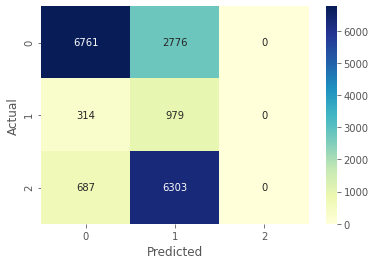

In [ ]:
# confusion matrix with 0.13 threshold
evaluation(y_valid,y_pred_label_lgb_v3)

In [ ]:
plotroc(y_valid,y_pred_proba_lgb_v3)

ValueError: ignored

In [ ]:
plotpr(y_valid,y_pred_proba_lgb_v3)

ValueError: ignored

In [ ]:
print('LGBM Base Accuracy : {}'.format(accuracy_score(y_valid,y_pred_label_lgb_v3)))
print('LGBM Base ROC_AUC_SCORE: {}'.format(roc_auc_score(y_valid,y_pred_proba_lgb_v3)))

LGBM Base Accuracy : 0.43434343434343436


ValueError: ignored

In [ ]:
#Feature Importance:
lgbfit.params

{'bagging_fraction': 0.8815457275141878,
 'bagging_freq': 4,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.4111913608168683,
 'feature_pre_filter': False,
 'is_unbalance': True,
 'lambda_l1': 1.1241759240062597,
 'lambda_l2': 0.29318308624074085,
 'learning_rate': 0.025555410893855032,
 'max_depth': 15,
 'metric': 'auc',
 'min_child_samples': 20,
 'num_leaves': 428,
 'objective': 'binary',
 'verbosity': -1}

{'objective': 'binary',
 'metric': 'auc',
 'is_unbalance': True,
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'feature_pre_filter': False,
 'learning_rate': 0.023588863860096287,
 'max_depth': 9,
 'num_leaves': 44,
 'bagging_fraction': 0.7238748686100216,
 'feature_fraction': 0.45275413742542336,
 'bagging_freq': 10,
 'lambda_l1': 9.607012688079987,
 'lambda_l2': 0.3611201594309046,
 'min_child_samples': 33,
 'num_iterations': 2000,
 'early_stopping_round': 100,
 'categorical_column': [0,
  2,
  3,
  4,
  5,
  6,
  8,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40]}

In [ ]:
import pickle

In [ ]:
# save best model to local disk
filename = 'finalized_lightgbm_model.sav'
pickle.dump(lgbfit, open(filename, 'wb'))

**load the model from disk**
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

### 5. Prediction on Test File

**5A) import test set**

In [ ]:
from google.colab import files
uploaded = files.upload()

data_test_orig = pd.read_csv("test_clean_completed.csv")

Saving test_clean_completed.csv to test_clean_completed.csv


In [ ]:
data_test_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             14850 non-null  int64  
 1   amount_tsh                     14850 non-null  float64
 2   funder                         14850 non-null  object 
 3   gps_height                     14850 non-null  float64
 4   installer                      13973 non-null  object 
 5   longitude                      14850 non-null  float64
 6   latitude                       14850 non-null  float64
 7   basin                          14850 non-null  object 
 8   region                         14850 non-null  object 
 9   district_code                  14850 non-null  int64  
 10  lga                            14850 non-null  object 
 11  ward                           14850 non-null  object 
 12  population                     14850 non-null 

In [ ]:
X_test = data_test_orig

In [ ]:
# make sure columns are matched as the lgbm defines categorical variables based on indexes
print(X_train.columns)
print(X_test.columns)

print(X_train.shape)
print(X_test.shape)

X_train.head(2)

Index(['id', 'amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'district_code', 'population', 'public_meeting', 'permit',
       'construction_year', 'payment_type', 'water_quality', '10_yrs',
       'gps_height_bad', 'longitude_bad', 'latitude_bad', 'region_encoded',
       'scheme_management_encoded', 'management_encoded',
       'waterpoint_type_encoded', 'extraction_type_class_encoded',
       'lga_encoded', 'ward_encoded', 'source_encoded', 'basin_encoded',
       'quantity_encoded', 'quality_group_encoded', 'region_district',
       'schemeM_scheme', 'waterpoint_extraction', 'extraction_source',
       'basin_qualityG', 'funder_cat', 'installer_cat', 'population_binned',
       'amount_tsh_is_zero', 'amount_tsh_bin'],
      dtype='object')
Index(['id', 'amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'basin', 'region', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'scheme_management', 'per

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,district_code,population,public_meeting,permit,construction_year,payment_type,water_quality,10_yrs,gps_height_bad,longitude_bad,latitude_bad,region_encoded,scheme_management_encoded,management_encoded,waterpoint_type_encoded,extraction_type_class_encoded,lga_encoded,ward_encoded,source_encoded,basin_encoded,quantity_encoded,quality_group_encoded,region_district,schemeM_scheme,waterpoint_extraction,extraction_source,basin_qualityG,funder_cat,installer_cat,population_binned,amount_tsh_is_zero,amount_tsh_bin
34690,20061,0.00000000,213,1415.13735178,2043,33.36564309,-8.87791995,2,281,1,1,2000,3,6,0,1,0,0,10,8,11,1,0,60,2042,6,2,1,2,66,19,0,7,16,0,24,2.00000000,1,0
914,15975,0.00000000,338,314.00000000,464,38.79987731,-10.55441685,33,350,1,1,1977,2,6,3,0,0,0,12,8,7,6,3,57,910,7,7,0,2,32,0,5,13,3,14,14,2.00000000,1,0


In [ ]:
X_test.head(2)

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type_class,management,payment_type,water_quality,quality_group,quantity,source,waterpoint_type,10_yrs,status_group,gps_height_bad,longitude_bad,latitude_bad,region_encoded,scheme_management_encoded,management_encoded,waterpoint_type_encoded,extraction_type_class_encoded,lga_encoded,ward_encoded,source_encoded,basin_encoded,quantity_encoded,quality_group_encoded,region_district,schemeM_scheme,waterpoint_extraction,extraction_source,basin_qualityG,funder_cat,installer_cat,population_binned,amount_tsh_is_zero,amount_tsh_bin
0,50785,0.00000000,Dmdd,1996.00000000,DMDD,35.29079920,-4.05969643,Internal,Manyara,3,Mbulu,Bashay,321,True,Parastatal,True,2012,other,parastatal,never pay,soft,good,seasonal,rainwater harvesting,other,10s,,0,0,0,8,2,3,6,3,63,17,5,0,3,2,0,0,0,0,0,14,14,2.00000000,1,0-1
1,51630,0.00000000,Government Of Tanzania,1569.00000000,DWE,36.65670893,-3.30921425,Pangani,Arusha,2,Arusha Rural,Kimnyaki,300,True,VWC,True,2000,gravity,vwc,never pay,soft,good,insufficient,spring,communal standpipe,00s,NaN,0,0,0,0,7,7,1,0,0,650,8,5,2,2,1,1,1,1,1,7,6,2.00000000,1,0-1


In [ ]:
y_pred_proba_lgb_test = lgbfit.predict(X_test,num_iteration=n_estimators)
y_pred_label_lgb_test = np.where(y_pred_proba_lgb_test>0.31,1,0)
y_pred_proba_lgb_test, y_pred_label_lgb_test

ValueError: ignored

In [ ]:
y_pred_test = pd.DataFrame({'response_pred_probability':y_pred_proba_lgb_test,
                            'response_pred_label_at_thresh0.31':y_pred_label_lgb_test},
                           columns=['response_pred_probability','response_pred_label_at_thresh0.31'])
y_pred_test.head()

,response_pred_probability,response_pred_label_at_thresh0.31
0,0.00462204,0
1,0.77136163,1
2,0.74199004,1
3,0.02722591,0
4,0.00304597,0


In [ ]:
test_with_pred = pd.concat([data_test_orig,y_pred_test], axis=1)

In [ ]:
test_with_pred.head()

,Unnamed: 0,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Age_0-24years,Age_25-33years,Age_34-45years,Age_46-60years,Age_above60years,Vintage_0-100days,Vintage_101-200days,Vintage_201-300days,Vehicle_Age_Damage,Previously_Insured_Vehicle_Damage,Age_0-24years_Previously_Insured,Age_25-33years_Previously_Insured,Age_34-45years_Previously_Insured,Age_46-60years_Previously_Insured,Age_above60years_Previously_Insured,Age_0-24years_Vehicle_Age_Vehicle_Damage,Age_25-33years_Vehicle_Age_Vehicle_Damage,Age_34-45years_Vehicle_Age_Vehicle_Damage,Age_46-60years_Vehicle_Age_Vehicle_Damage,Age_above60years_Vehicle_Age_Vehicle_Damage,Vintage_0-100days_Previously_Insured,Vintage_101-200days_Previously_Insured,Vintage_201-300days_Previously_Insured,Vintage0-100days_Vehicle_Age_Vehicle_Damage,Vintage101-200days_Vehicle_Age_Vehicle_Damage,Vintage201-300days_Vehicle_Age_Vehicle_Damage,Gender_Previously_Insured,Gender_Vehicle_Age_Vehicle_Damage,Gender_Vintage0-100days,Gender_Vintage101-200days,Gender_Vintage201-300days,response_pred_probability,response_pred_label_at_thresh0.31
0,0,381110,1,25,1,11,1,1,0,35786,152,53,0,1,0,0,0,1,0,0,1,3,4,2,4,4,4,7,1,7,7,7,2,4,4,1,7,7,1,1,1,3,3,0.00462204,0
1,1,381111,1,40,1,28,0,2,1,33762,7,111,0,0,1,0,0,0,1,0,5,2,3,3,1,3,3,11,11,5,11,11,3,1,3,11,5,11,2,5,3,1,3,0.77136163,1
2,2,381112,1,47,1,28,0,2,1,40050,124,199,0,0,0,1,0,0,1,0,5,2,3,3,3,1,3,11,11,11,5,11,3,1,3,11,5,11,2,5,3,1,3,0.74199004,1
3,3,381113,1,24,1,27,1,1,1,37356,152,187,1,0,0,0,0,0,1,0,4,4,2,4,4,4,4,4,10,10,10,10,4,2,4,10,4,10,1,4,3,1,3,0.02722591,0
4,4,381114,1,27,1,28,1,1,0,59097,152,297,0,1,0,0,0,0,0,1,1,3,4,2,4,4,4,7,1,7,7,7,4,4,2,7,7,1,1,1,3,3,1,0.00304597,0


In [ ]:
test_with_pred['response_pred_label_at_thresh0.31'].value_counts()

0    68606
1    58431
Name: response_pred_label_at_thresh0.31, dtype: int64

In [ ]:
test_with_pred['response_pred_label_at_thresh0.31'].value_counts(normalize=True)

0   0.54004739
1   0.45995261
Name: response_pred_label_at_thresh0.31, dtype: float64

In [ ]:
test_with_pred['response_pred_decile'] = 10-pd.qcut(test_with_pred['response_pred_probability'], 10, labels=False)

In [ ]:
test_with_pred.groupby(['response_pred_decile'],as_index=False).agg({'response_pred_probability':{'min','max'},
                                                                     'id':'count'})

response_pred_decile response_pred_probability                id
                                             min        max  count
0                    1                0.79108692 0.91184495  12704
1                    2                0.74157206 0.79108343  12704
2                    3                0.65352320 0.74157174  12703
3                    4                0.49126883 0.65350534  12704
4                    5                0.16748813 0.49119652  12703
5                    6                0.00596588 0.16747933  12704
6                    7                0.00291645 0.00596548  12704
7                    8                0.00211684 0.00291638  12703
8                    9                0.00168653 0.00211679  12704
9                   10                0.00079691 0.00168650  12704

In [ ]:
test_with_pred.to_csv('Insurance_Test_Prediction.csv', encoding='utf-8', index=False)